In [2]:
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
import random
import math
from scipy import stats
import pandas as pd
import seaborn as sns
%matplotlib inline

def getDistribution(keys, normalized = True):
    
    uniq_keys = np.unique(keys)
    bins = uniq_keys.searchsorted(keys)
    distr = np.bincount(bins) 

    if normalized == 1: distr = distr/float(np.sum(distr)) 

    return np.asarray(uniq_keys.tolist()), np.asarray(distr.tolist())


def getPercentileBinnedDistribution(x, y, nbins):

    x, y = zip(*sorted(zip(x, y), key=lambda tup: tup[0]))
    elements_per_bin = int(len(x)/float(nbins))

    xx  = [np.mean(x[i*elements_per_bin:(i+1)*elements_per_bin]) for i in range(nbins)]
    yy  = [np.mean(y[i*elements_per_bin:(i+1)*elements_per_bin]) for i in range(nbins)]
    std = [np.std(y[i*elements_per_bin:(i+1)*elements_per_bin])  for i in range(nbins)]

    return xx, yy, std


def getLogBinnedDistribution(x, y, nbins):

    bins   = 10 ** np.linspace(np.log10(min(x)), np.log10(max(x)), nbins)  
    values = [ np.mean([y[j]  for j in range(len(x)) if x[j] >= bins[i] and x[j] < bins[i+1]])  for i in range(nbins-1)]    
    error  = [ np.std( [y[j]  for j in range(len(x)) if x[j] >= bins[i] and x[j] < bins[i+1]])  for i in range(nbins-1)]
    bins   = (bins[1:] + bins[:-1])/2

    return bins, values, error

# Check the impact distribution

Just for quick sanity check, with log binning and without fitting here. 

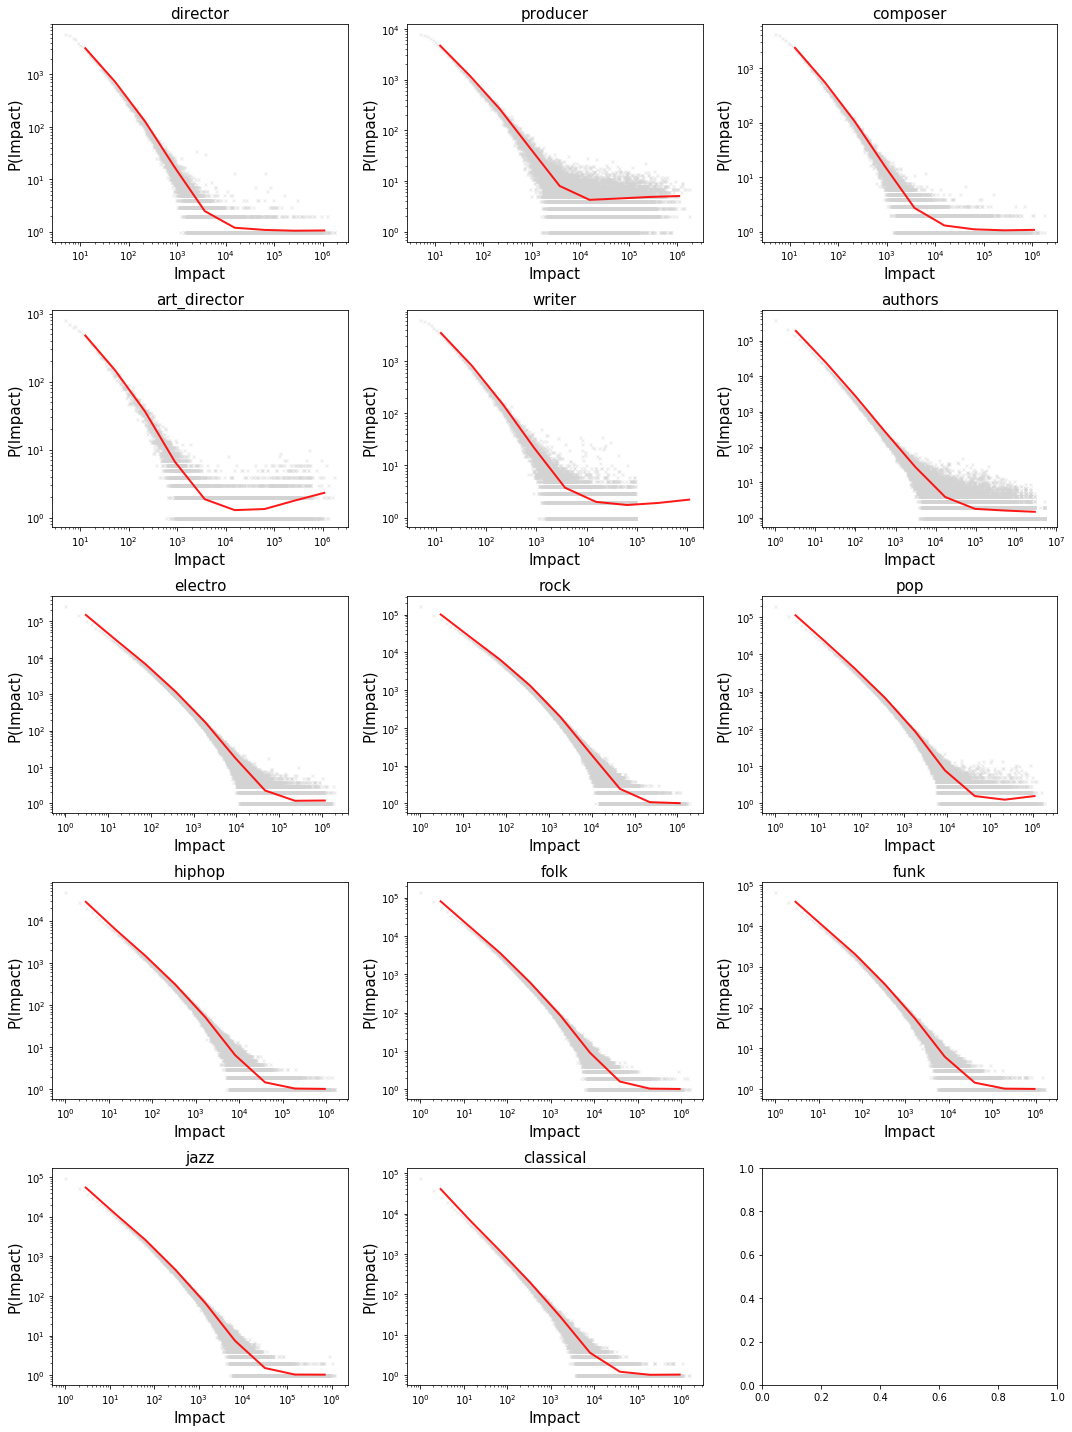

In [2]:
def plot_impact_distr(field, ax):
    
    ibinned = 'DataToPlot/1_impact_distribution/1_impact_distribution_binned_' + field + '.dat'
    idata   = 'DataToPlot/1_impact_distribution/1_impact_distribution_data_'   + field + '.dat'

    bx, by = zip(*[ tuple([float(fff) for fff in line.strip().split('\t')])  for line in open(ibinned) ])
    x,  y  = zip(*[ tuple([float(fff) for fff in line.strip().split('\t')])  for line in open(idata) ])

    ax.plot(x,  y, 'o', marker = 'x', markersize = 3, color = 'lightgrey', alpha = 0.4)
    ax.plot(bx, by, color = 'r', alpha = 0.9, linewidth = 2)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(field.split('-')[0], fontsize = 15)

    ax.set_xlabel('Impact', fontsize = 15)
    ax.set_ylabel('P(Impact)', fontsize = 15)
    
f, ax = plt.subplots(5,3, figsize = (15,20))
plot_impact_distr('director-10',     ax[0,0])  
plot_impact_distr('producer-10',     ax[0,1]) 
plot_impact_distr('composer-10',     ax[0,2])  
plot_impact_distr('art_director-10', ax[1,0]) 
plot_impact_distr('writer-10',       ax[1,1])  
plot_impact_distr('authors-10',      ax[1,2])

plot_impact_distr('electro-20',    ax[2,0])
plot_impact_distr('rock-20',       ax[2,1])
plot_impact_distr('pop-20',        ax[2,2])
plot_impact_distr('hiphop-20',     ax[3,0])
plot_impact_distr('folk-20',       ax[3,1])
plot_impact_distr('funk-20',       ax[3,2])
plot_impact_distr('jazz-20',       ax[4,0])
plot_impact_distr('classical-20',  ax[4,1])

plt.tight_layout()


# R-rule - N*/N plots

The numbers indicate the lower cutoff of the career lengths, errorbars are the stdev of values within the bins. Probably better binning could make it nicer, now its just linear binning.

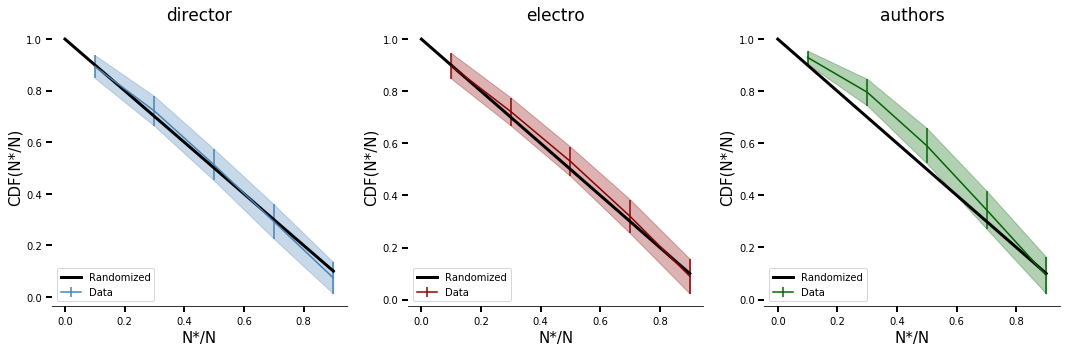

In [66]:
def get_N_star_N_plot_new(field, ax, color):
    
    xx, yy, yerr = zip(*[ (float(fff) for fff in line.strip().split('\t')) for line in open('DataToPlot/2_N_Nstar/' + field + '_NNstar_data.dat' )])
    
    x = np.arange(0,1, 0.1)
    ax.plot(x,[1.0 -  xi for xi in x], color ='k', linewidth = 3, alpha = 1.0, label= 'Randomized')

    ax.errorbar(xx, yy, yerr = yerr, color = color, label = 'Data')  
    ax.fill_between(xx, np.asarray(yy)- np.asarray(yerr), np.asarray(yy) + np.asarray(yerr), color = color, alpha = 0.3)

    ax.set_title(field, fontsize = 17)
    
    ax.set_ylabel('CDF(N*/N)', fontsize = 15)
    ax.set_xlabel('N*/N', fontsize = 15)
    
    for pos in ['right', 'top', 'left']:
        ax.spines[pos].set_edgecolor('white')    

    ax.tick_params(axis='x', length=6, width=2, colors='black')
    ax.tick_params(axis='y', length=6, width=2, colors='black')       
    ax.legend(loc = 'lower left', fontsize = 10)


    
    
f, ax = plt.subplots(1,3, figsize = (15,5))

get_N_star_N_plot_new('director',  ax[0], 'steelblue')
get_N_star_N_plot_new('electro',   ax[1], 'darkred')
get_N_star_N_plot_new('authors',   ax[2], 'darkgreen')


plt.tight_layout()

plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/F2.png')

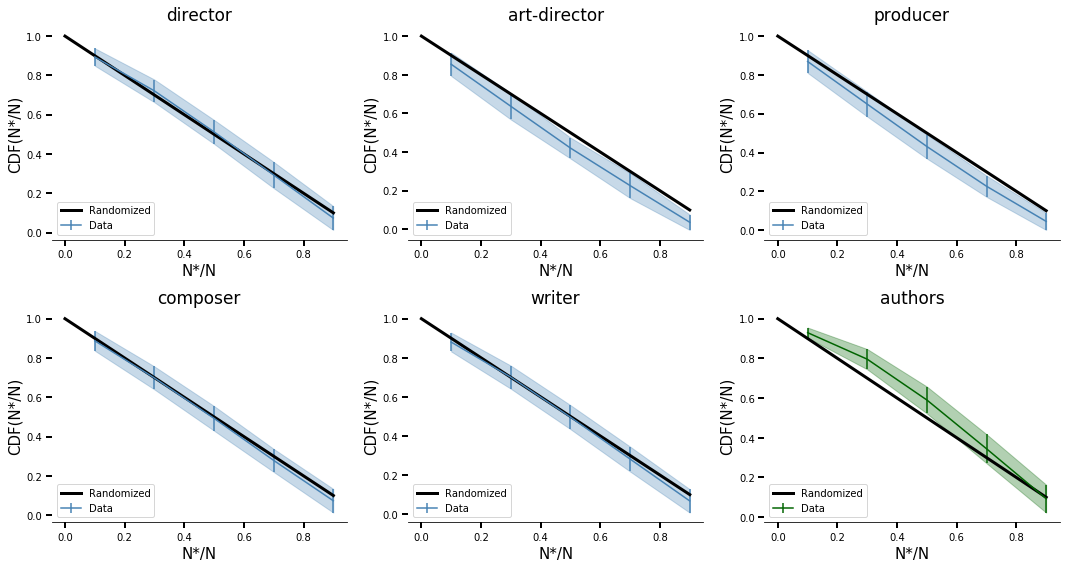

In [69]:
f, ax = plt.subplots(2,3, figsize = (15,8))

get_N_star_N_plot_new('director',      ax[0,0], 'steelblue')
get_N_star_N_plot_new('art-director',  ax[0,1], 'steelblue')
get_N_star_N_plot_new('producer',      ax[0,2], 'steelblue')
get_N_star_N_plot_new('composer',      ax[1,0], 'steelblue')
get_N_star_N_plot_new('writer',        ax[1,1], 'steelblue')
get_N_star_N_plot_new('authors',       ax[1,2], 'darkgreen')


plt.tight_layout()

plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/S2a.png')


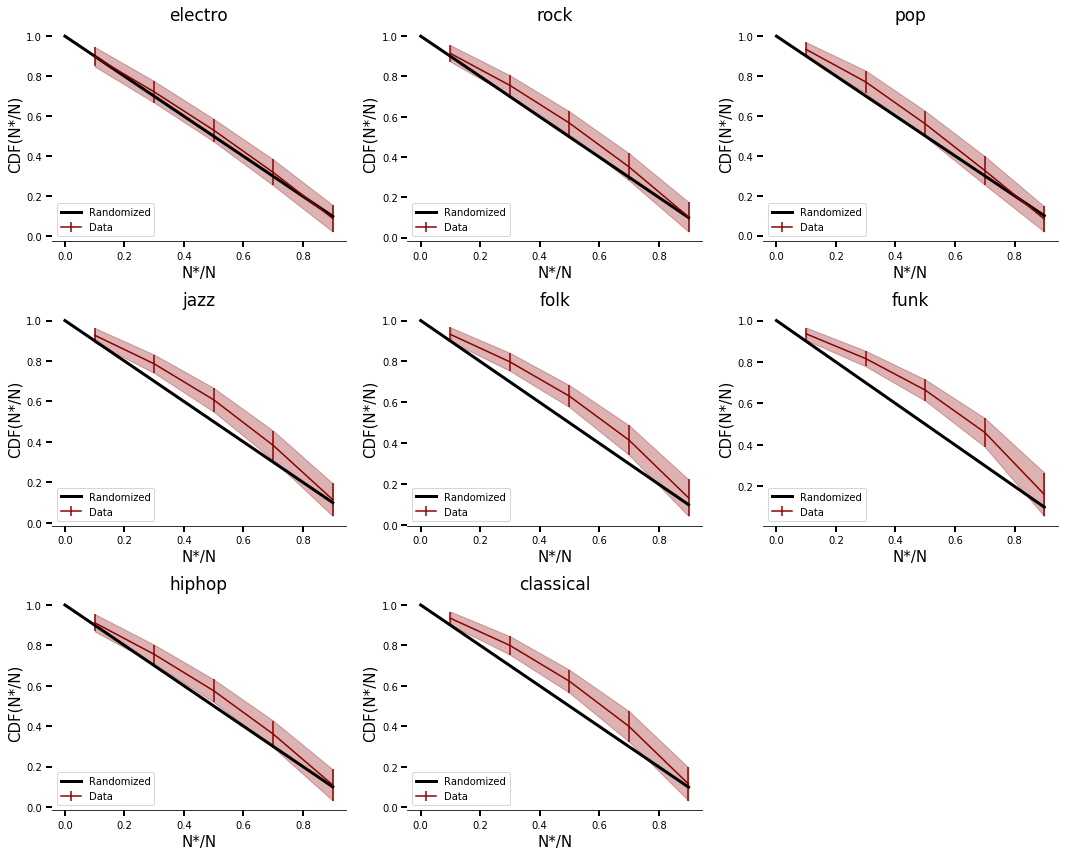

In [74]:
f, ax = plt.subplots(3,3, figsize = (15,12))


get_N_star_N_plot_new('electro',    ax[0,0], 'darkred')
get_N_star_N_plot_new('rock',       ax[0,1], 'darkred')
get_N_star_N_plot_new('pop',        ax[0,2], 'darkred')
get_N_star_N_plot_new('jazz',       ax[1,0], 'darkred')
get_N_star_N_plot_new('folk',       ax[1,1], 'darkred')
get_N_star_N_plot_new('funk',       ax[1,2], 'darkred')
get_N_star_N_plot_new('hiphop',     ax[2,0], 'darkred')
get_N_star_N_plot_new('classical',  ax[2,1], 'darkred')

ax[2,2].axis('off')

plt.tight_layout()

plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/S2b.png')

# p and Q distributions

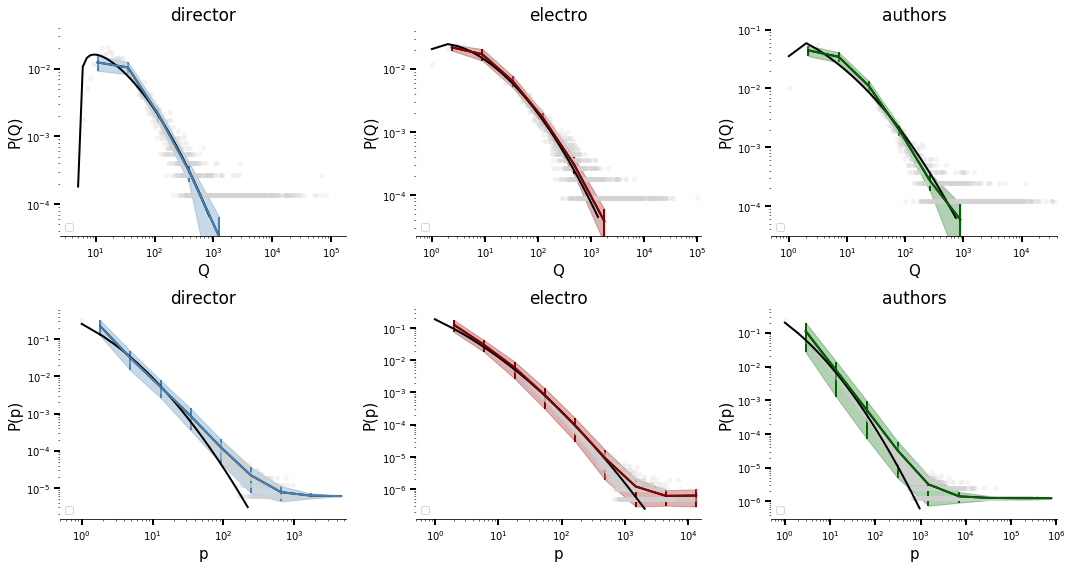

In [30]:
def do_p_Q_plots(field, bx, color, tipus, nbins):
    
    Qdata    = 'DataToPlot/3_pQ_distributions_processed/' + field + '_' + tipus + 'data.dat'
    Qfit     = 'DataToPlot/3_pQ_distributions_processed/' + field + '_' + tipus + 'fit.dat'
    Qbinned  = 'DataToPlot/3_pQ_distributions_processed/' + field + '_' + tipus + 'binned.dat'
      
        
    Qx,    Qy        = zip(*[ [float(fff) for fff in line.strip().split('\t')] for line in open(Qdata)])
    fQx,  fQy        = zip(*[ [float(fff) for fff in line.strip().split('\t')] for line in open(Qfit)])
    bQx,  bQy, berr  = zip(*[ [float(fff) for fff in line.strip().split('\t')] for line in open(Qbinned)])
  
    
    bx.plot(Qx,   Qy, 'o', color = 'lightgrey', alpha = 0.2, linewidth = 0, markersize = 4)
    bx.plot(fQx, fQy,      color = 'k', linewidth = 2)
    bx.errorbar(bQx, bQy,  yerr  = berr ,   color = 'k', linewidth = 2)
    bx.errorbar(bQx, bQy,  yerr = berr, linewidth = 2, color = color)
    bx.fill_between(bQx, np.asarray(bQy)- np.asarray(berr), np.asarray(bQy) + np.asarray(berr), color = color, alpha = 0.3)
      
    
    bx.set_xscale('log')
    bx.set_yscale('log')
    bx.set_title(field + ' - P(' + tipus + ')', fontsize = 15)    

    bx.set_ylabel('P(' + tipus + ')', fontsize = 15)
    bx.set_xlabel(tipus, fontsize = 15) 
    
    bx.set_ylim([0.25*min(Qy), 2*max(Qy)])
    bx.set_xlim([0.5*min(Qx), 0.8*max(Qx)])
      
    bx.set_ylabel('P(' + tipus + ')', fontsize = 15)
    bx.set_xlabel(tipus, fontsize = 15)
    
    for pos in ['right', 'top', 'left']:
        bx.spines[pos].set_edgecolor('white')    

    bx.tick_params(axis='x', length=6, width=2, colors='black')
    bx.tick_params(axis='y', length=6, width=2, colors='black')       
    bx.legend(loc = 'lower left', fontsize = 10)
  
    bx.set_title(field.split('-')[0], fontsize = 17)

    for pos in ['right', 'top', 'left']:
        bx.spines[pos].set_edgecolor('white')    

    bx.tick_params(axis='x', length=6, width=2, colors='black')
    bx.tick_params(axis='y', length=6, width=2, colors='black')       
    bx.legend(loc = 'lower left', fontsize = 10)

 
  
    
f, ax = plt.subplots(2,3, figsize = (15,8,))

do_p_Q_plots('director-10', ax[0,0], 'steelblue', 'Q', 10) 
do_p_Q_plots('director-10', ax[1,0], 'steelblue', 'p', 10)

do_p_Q_plots('electro-80', ax[0,1], 'darkred', 'Q', 10) 
do_p_Q_plots('electro-80', ax[1,1], 'darkred', 'p', 10)

do_p_Q_plots('authors-50', ax[0,2], 'darkgreen', 'Q', 10) 
do_p_Q_plots('authors-50', ax[1,2], 'darkgreen', 'p', 10)

plt.tight_layout()


plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/F3.png')

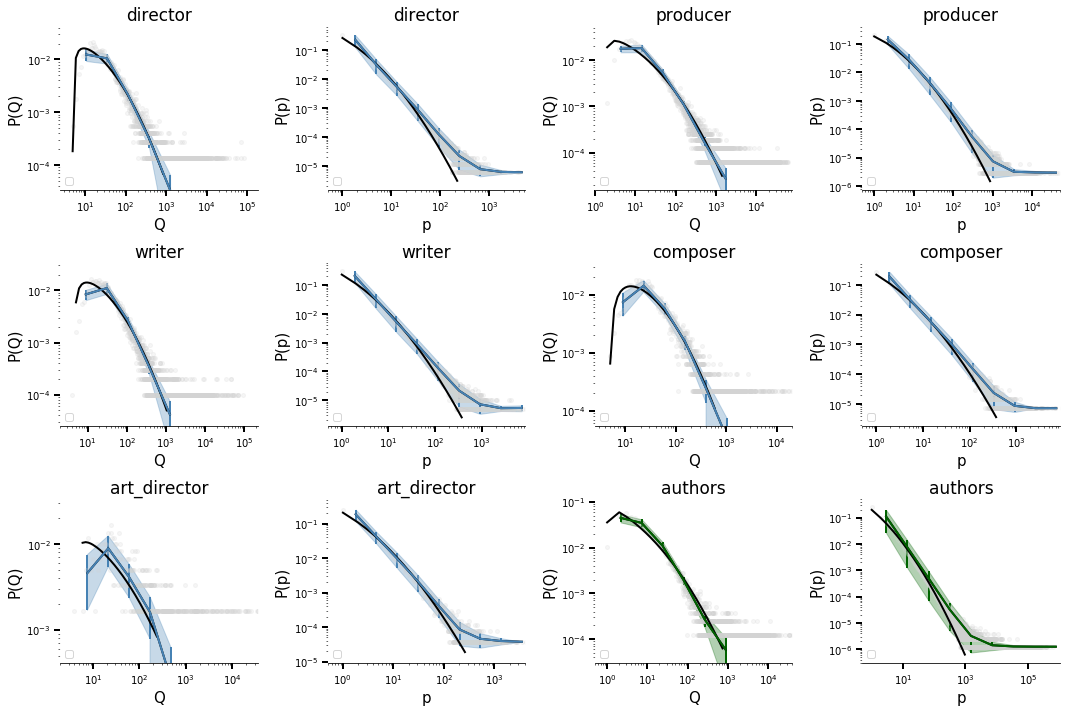

In [31]:
f, ax = plt.subplots(3,4, figsize = (15,10))

do_p_Q_plots('director-10', ax[0,0], 'steelblue', 'Q', 10) 
do_p_Q_plots('director-10', ax[0,1], 'steelblue', 'p', 10)

do_p_Q_plots('producer-10', ax[0,2], 'steelblue', 'Q', 10) 
do_p_Q_plots('producer-10', ax[0,3], 'steelblue', 'p', 10)


do_p_Q_plots('writer-10', ax[1,0], 'steelblue', 'Q', 10) 
do_p_Q_plots('writer-10', ax[1,1], 'steelblue', 'p', 10)

do_p_Q_plots('composer-10', ax[1,2], 'steelblue', 'Q', 10) 
do_p_Q_plots('composer-10', ax[1,3], 'steelblue', 'p', 10)


do_p_Q_plots('art_director-20', ax[2,0], 'steelblue', 'Q', 10) 
do_p_Q_plots('art_director-20', ax[2,1], 'steelblue', 'p', 10)

do_p_Q_plots('authors-50', ax[2,2], 'darkgreen', 'Q', 10) 
do_p_Q_plots('authors-50', ax[2,3], 'darkgreen', 'p', 10)

plt.tight_layout()

plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/S3a.png')

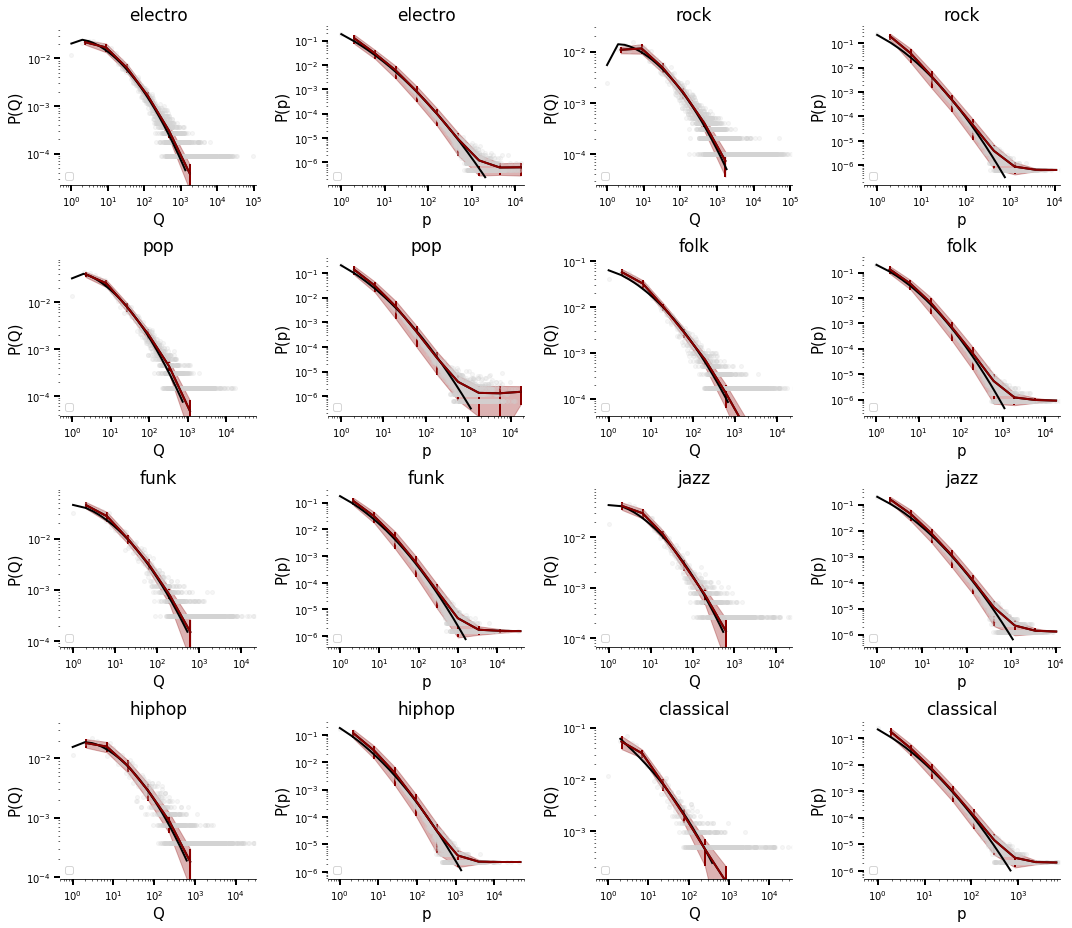

In [32]:
f, ax = plt.subplots(4,4, figsize = (15,13))

do_p_Q_plots('electro-80', ax[0,0], 'darkred', 'Q', 10) 
do_p_Q_plots('electro-80', ax[0,1], 'darkred', 'p', 10)

do_p_Q_plots('rock-80', ax[0,2], 'darkred', 'Q', 10) 
do_p_Q_plots('rock-80', ax[0,3], 'darkred', 'p', 10)

do_p_Q_plots('pop-80', ax[1,0],  'darkred', 'Q', 10) 
do_p_Q_plots('pop-80', ax[1,1],  'darkred', 'p', 10)

do_p_Q_plots('folk-80', ax[1,2], 'darkred', 'Q', 10) 
do_p_Q_plots('folk-80', ax[1,3], 'darkred', 'p', 10)

do_p_Q_plots('funk-80', ax[2,0], 'darkred', 'Q', 10) 
do_p_Q_plots('funk-80', ax[2,1], 'darkred', 'p', 10)

do_p_Q_plots('jazz-80', ax[2,2], 'darkred', 'Q', 10) 
do_p_Q_plots('jazz-80', ax[2,3], 'darkred', 'p', 10)

do_p_Q_plots('hiphop-80', ax[3,0], 'darkred', 'Q', 10) 
do_p_Q_plots('hiphop-80', ax[3,1], 'darkred', 'p', 10)

do_p_Q_plots('classical-80', ax[3,2], 'darkred', 'Q', 10) 
do_p_Q_plots('classical-80', ax[3,3], 'darkred', 'p', 10)



plt.tight_layout()

plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/S3b.png')

# Individual luck curves 

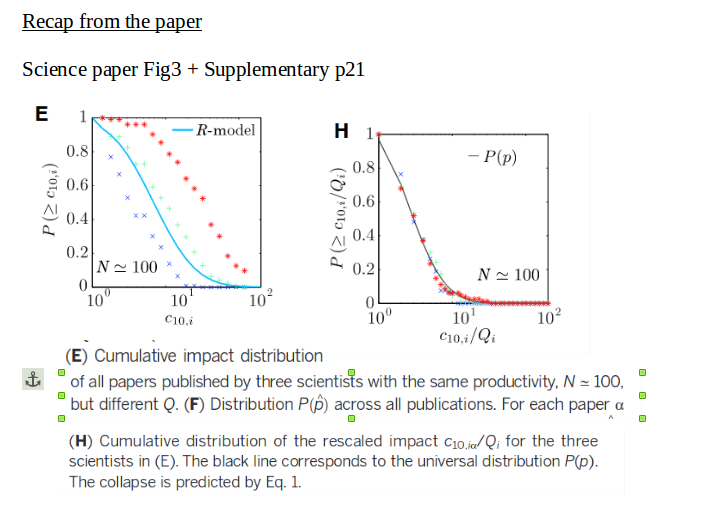

In [23]:
def get_luck_curves(field, ax, color, lim, mmin):
    
    data    = 'DataToPlot/3_pQ_distributions/p_values_of_users_' + field + '.dat'
    pvalues = {} 
    
    ijk = 0
    
    for ind, line in enumerate(open(data)):
              
        
        fields = line.strip().split('\t') 
        X = [float(x) for x in fields[1].split(';')]
        Y = [float(y) for y in fields[2].split(';')]
        
        if 'everybody' not in line:
            if len(X) > mmin and ijk < 50:
                ax.plot(X,Y, linewidth = 1.0, color = 'lightgrey', alpha = 0.25)    
                ijk += 1

        else:
            ax.plot(X,Y, linewidth = 3.5, alpha = 0.9, color = color)        
 
       
    ax.set_xscale('log')
    ax.set_title(field.split('-')[0] + ',  N > 200', fontsize = 16)
    ax.set_xlim(lim)        
        
    ax.set_ylabel('CDF(p_i,alpha)', fontsize = 15)
    ax.set_xlabel('p_i,alpha', fontsize = 15)    
    

    for pos in ['right', 'top', 'left']:
        ax.spines[pos].set_edgecolor('white')    

    ax.tick_params(axis='x', length=6, width=2, colors='black')
    ax.tick_params(axis='y', length=6, width=2, colors='black')       
    # ax.legend(loc = 'lower left', fontsize = 10)


    
    
    
    field = field.split('-')[0] + ' N >= ' + field.split('-')[1].split('_')[0]
    
    ax.set_title(field, fontsize = 16)

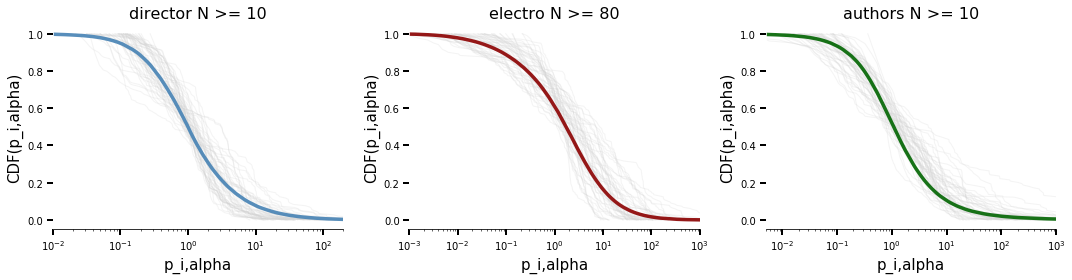

In [24]:
f, ax = plt.subplots(1,3, figsize = (15, 4))

get_luck_curves('director-10_0', ax[0], 'steelblue', [0.01,   200], 50)
get_luck_curves('electro-80_0',  ax[1], 'darkred',   [0.001, 1000], 50)
get_luck_curves('authors-10_0',  ax[2], 'darkgreen', [0.005, 1000], 50)

plt.tight_layout()

plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/F5.png')

38
50
50
50
50
50


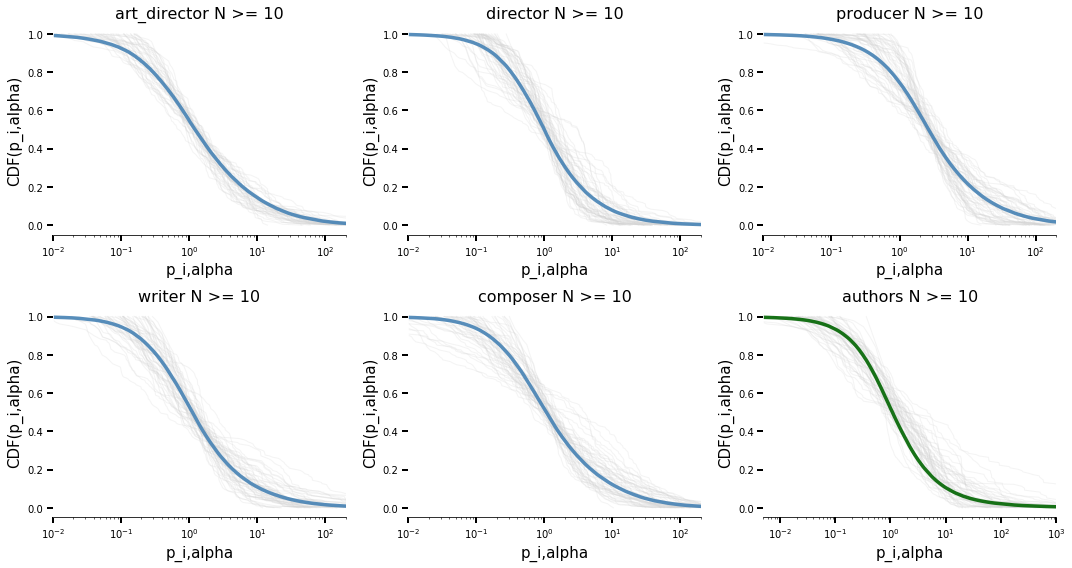

In [249]:
f, ax = plt.subplots(2,3, figsize = (15, 8))

get_luck_curves('art_director-10_0', ax[0,0], 'steelblue', [0.01,   200], 50)
get_luck_curves('director-10_0',     ax[0,1], 'steelblue', [0.01,   200], 50)
get_luck_curves('producer-10_0',     ax[0,2], 'steelblue', [0.01,   200], 50)
get_luck_curves('writer-10_0',       ax[1,0], 'steelblue', [0.01,   200], 50)
get_luck_curves('composer-10_0',     ax[1,1], 'steelblue', [0.01,   200], 50)
get_luck_curves('authors-10_0',      ax[1,2], 'darkgreen', [0.005, 1000], 50)

plt.tight_layout()
plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/S5a.png')

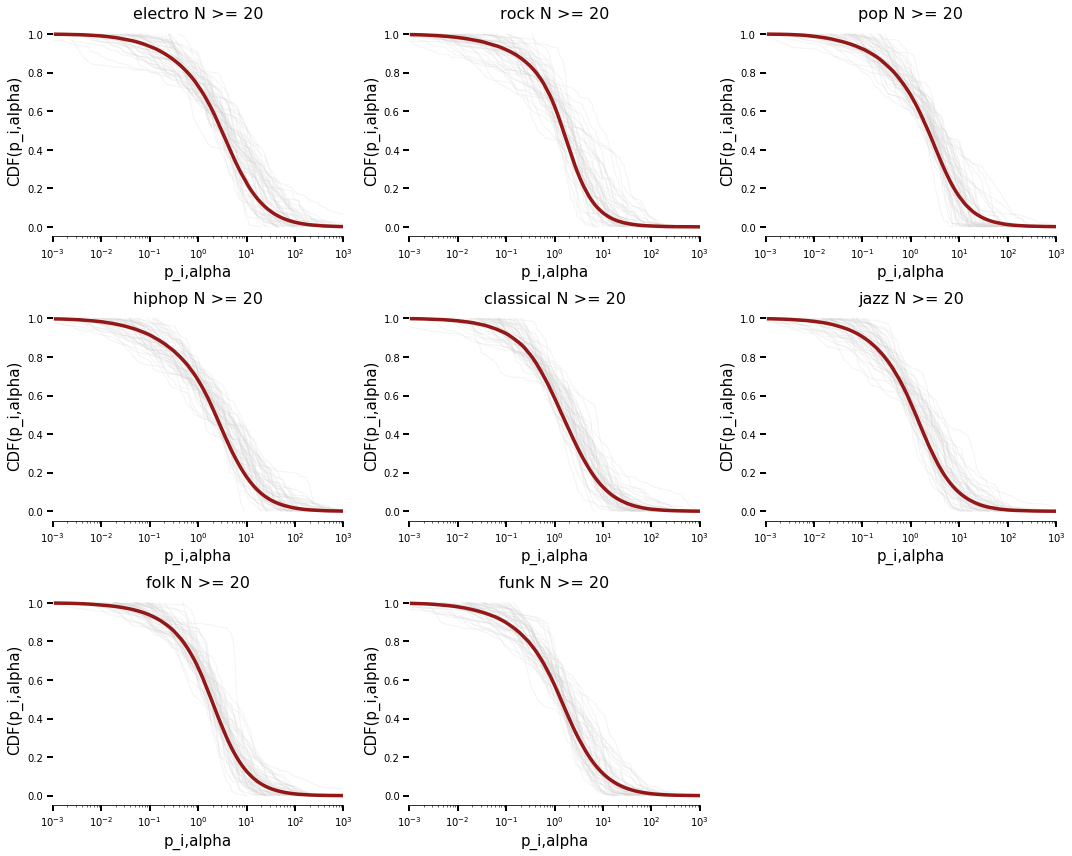

In [253]:
f, ax = plt.subplots(3,3, figsize = (15, 12))



get_luck_curves('electro-20_0',   ax[0,0], 'darkred',   [0.001, 1000], 50)
get_luck_curves('rock-20_0',      ax[0,1], 'darkred',   [0.001, 1000], 50)
get_luck_curves('pop-20_0',       ax[0,2], 'darkred',   [0.001, 1000], 50)

get_luck_curves('hiphop-20_0',    ax[1,0], 'darkred',   [0.001, 1000], 50)
get_luck_curves('classical-20_0', ax[1,1], 'darkred',   [0.001, 1000], 50)
get_luck_curves('jazz-20_0',      ax[1,2], 'darkred',   [0.001, 1000], 50)

get_luck_curves('folk-20_0',      ax[2,0], 'darkred',   [0.001, 1000], 50)
get_luck_curves('funk-20_0',      ax[2,1], 'darkred',   [0.001, 1000], 50)

ax[2,2].axis('off')

plt.tight_layout()
plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/S5b.png')

# Fittin the R and Q models onto the N - I* data

The length of the career vs the impact of the highest impact piece (more precisely log I). I show two different career length cutoffs, indicating the number of users being included on each plot. I use 10 bins with logarithmic binning, and the best solutions from the optimization. I also tried differetn solutions from the optimization (e.g. top 5) - they all show similar results. At the end, the plots look very similar. Haven't done R^2 stats yet.

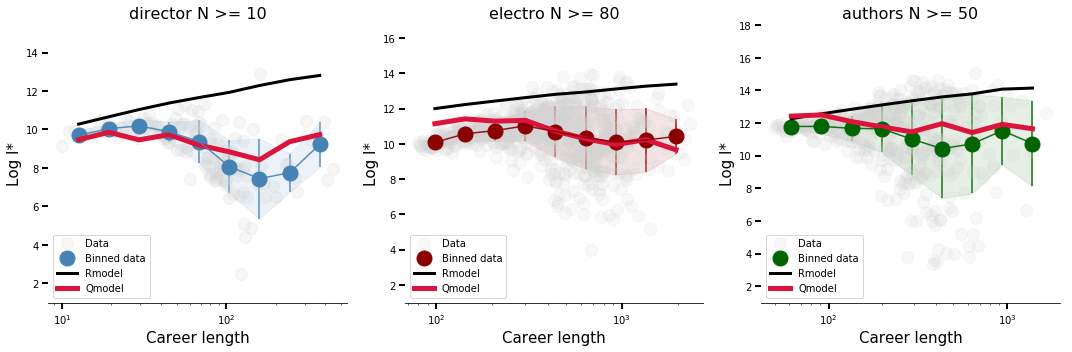

In [25]:
def plot_RQmodel(field, ax,  colors):

    root   = 'DataToPlot/4_RQModel/'
    data   = root + '4_RQModel_data_'   + field + '.dat'
    binned = root + '4_RQModel_binned_' + field + '.dat'
    rmodel = root + '4_RQModel_rmodel_' + field + '.dat'
    qmodel = root + '4_RQModel_qmodel_' + field + '.dat'

    x,    y     = zip(*[ tuple([float(fff) for fff in line.strip().split('\t')])   for line in open(data)    ])  
    bx,   by, e = zip(*[ tuple([float(fff) for fff in line.strip().split('\t')])   for line in open(binned)  ])
    bxR, byR    = zip(*[ tuple([float(fff) for fff in line.strip().split('\t')])   for line in open(rmodel)  ])
    bxQ, byQ    = zip(*[ tuple([float(fff) for fff in line.strip().split('\t')])   for line in open(qmodel)  ])

    
    NNN    = len(x)
    alpha_ = 1.0/math.log(NNN)
    
    
    
    ax.plot(x,  y,   'o', markersize = 12, alpha = alpha_, color = 'lightgrey', label = 'Data')#    ax.plot(bNs, bIstars, 'r', linewidth = 3)
    ax.plot(bx, by,  'o', color = colors, markersize = 15, label = 'Binned data')
    ax.errorbar(bx, by, yerr = e, color = colors, markersize = 15, alpha = 0.9)

    ax.plot(bxR, byR ,  'k', linewidth = 3, label= 'Rmodel')
    ax.plot(bxQ, byQ , 'g', linewidth = 5, color = 'crimson', label = 'Qmodel')
    
    
    
    ax.set_xscale('log')
    ax.set_ylim([1, 1.2*max(y)])
    ax.set_xlabel('Career length', fontsize = 15)
    ax.set_ylabel('Log I*', fontsize = 15)
    ax.fill_between(bx, np.asarray(by)- np.asarray(e), np.asarray(by) + np.asarray(e), color =  colors, alpha = 0.1)

    for pos in ['right', 'top', 'left']:
        ax.spines[pos].set_edgecolor('white')    
    
     #for pos in ['right', 'top', 'left', 'bottom']:
     #   ax.spines[pos].set_edgecolor('black')

    ax.tick_params(axis='x', length=6, width=2, colors='black')
    ax.tick_params(axis='y', length=6, width=2, colors='black')       
    #ax.set_xticklabels([])
    #ax.set_yticklabels([])
    ax.legend(loc = 'lower left', fontsize = 10)


    
    
    
    field = field.split('-')[0] + ' N >= ' + field.split('-')[1].split('_')[0]
    
    ax.set_title(field, fontsize = 16)

  
colors = {  'film' :  sns.color_palette("GnBu_d"),
            'book' :  sns.light_palette("green"),         
            'music' :  sns.light_palette("red"),         
         
         }


f, ax = plt.subplots(1,3, figsize = (15,5))
plot_RQmodel('director-10_0',  ax[0],  'steelblue'   )  
plot_RQmodel('electro-80_0',   ax[1], 'darkred'   )   
plot_RQmodel('authors-50_0',   ax[2], 'darkgreen')  



plt.tight_layout()  
plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/F4.png')

(0.21697808535178778, 0.3273356401384083, 0.36941176470588233)

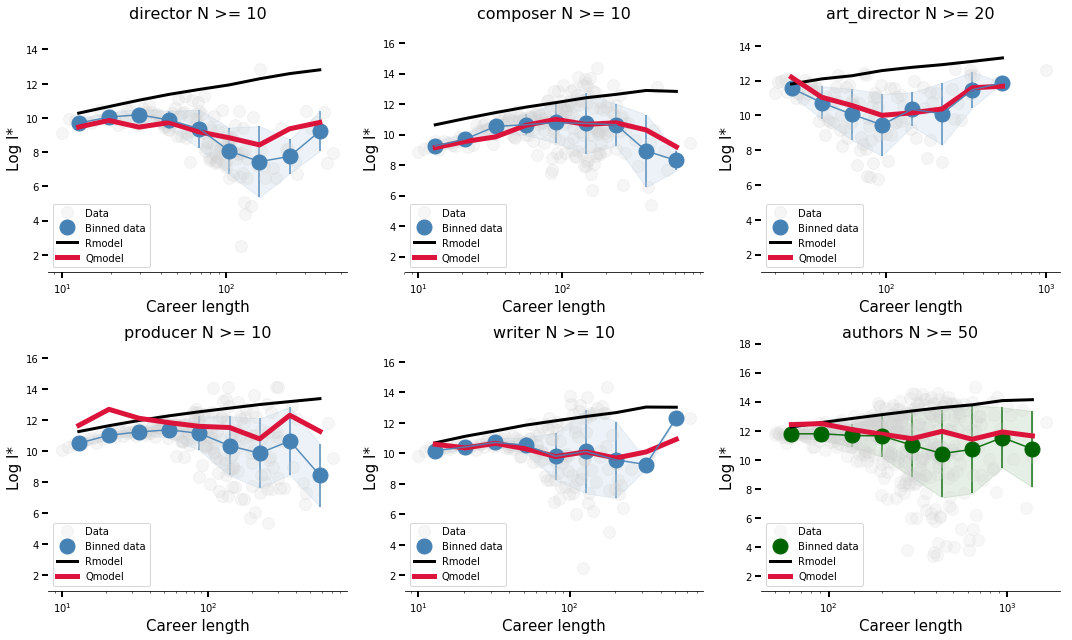

In [26]:
f, ax = plt.subplots(2,3, figsize = (15,9))
plot_RQmodel('director-10_0',     ax[0,0],  'steelblue'   )  
plot_RQmodel('composer-10_0',     ax[0,1],  'steelblue'   )  
plot_RQmodel('art_director-20_0', ax[0,2],  'steelblue'   )  
plot_RQmodel('producer-10_0',     ax[1,0],  'steelblue'   )  
plot_RQmodel('writer-10_0',       ax[1,1],  'steelblue'   )
plot_RQmodel('authors-50_0',      ax[1,2],  'darkgreen'   ) 

plt.tight_layout()
plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/S4a.png')

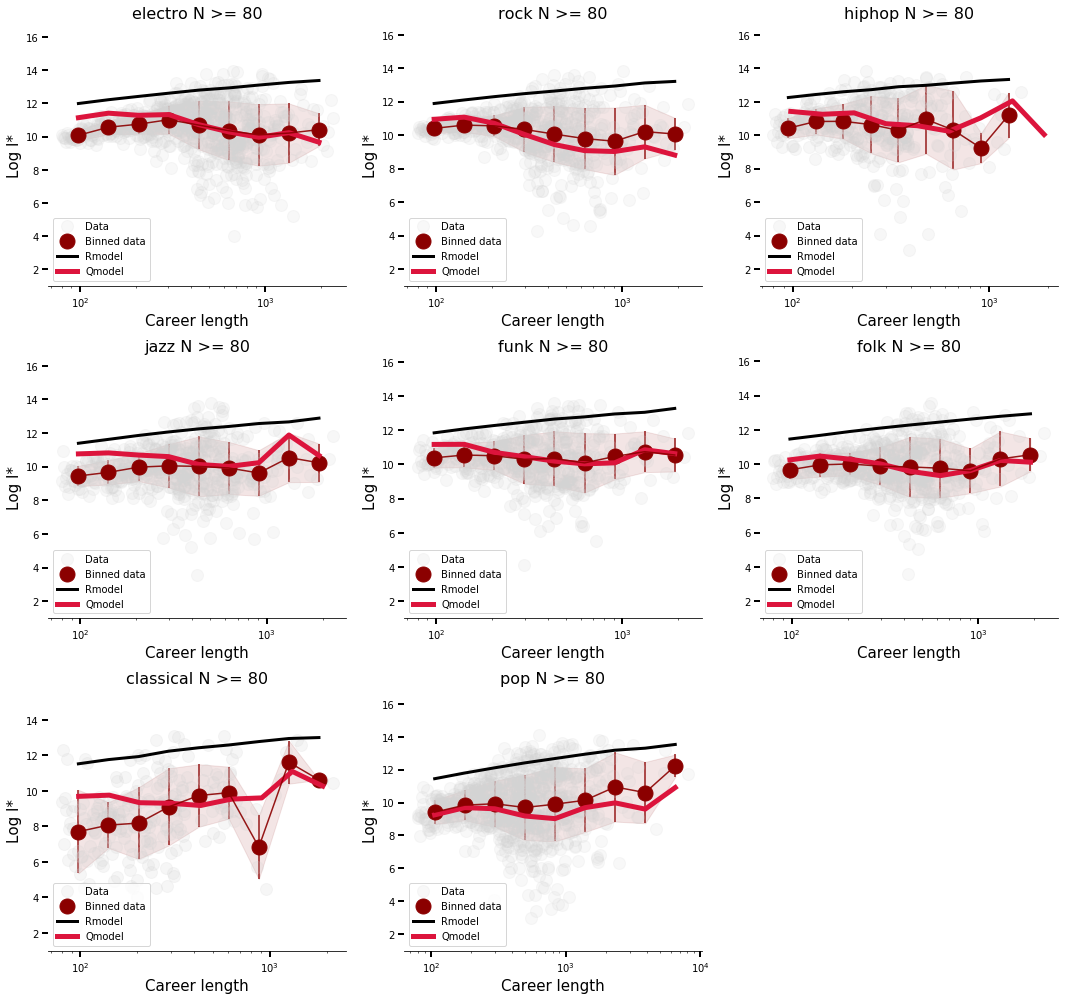

In [27]:
f, ax = plt.subplots(3,3, figsize = (15,14))

plot_RQmodel('electro-80_0',   ax[0,0], 'darkred') 
plot_RQmodel('rock-80_0',      ax[0,1], 'darkred') 
plot_RQmodel('hiphop-80_0',    ax[0,2], 'darkred')  
plot_RQmodel('jazz-80_0',      ax[1,0], 'darkred')  
plot_RQmodel('funk-80_0',      ax[1,1], 'darkred') 
plot_RQmodel('folk-80_0',      ax[1,2], 'darkred')
plot_RQmodel('classical-80_0', ax[2,0], 'darkred')
plot_RQmodel('pop-80_0',       ax[2,1], 'darkred')
ax[2,2].axis('off')

plt.tight_layout()
plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/S4b.png')

# Luck and skill

In [34]:
pdata = {}
qdata = {}

for line in open('DataToPlot/5_LuckSkill/p_avg_std.dat'):
    if '0_0.dat' in line:
        line  = line.strip().split('\t')
        field = line[0].replace('p_distribution_', '').rsplit('_', 1)[0]
        pavg  = float(line[1])
        pstd  = float(line[2])
        pdata[field] = pstd / pavg
        
        
for line in open('DataToPlot/5_LuckSkill/Q_avg_std.dat'):
    if '0_0.dat' in line:
        line  = line.strip().split('\t')
        field = line[0].replace('Q_distribution_', '').rsplit('_', 1)[0]
        qavg  = float(line[1])
        qstd  = float(line[2])                                                            
        qdata[field] = qstd / qavg
      
final_keys = ['art_director-20', 'authors-50','classical-80', 'composer-10', 'director-10', 'electro-80', 'folk-80',
             'funk-80', 'hiphop-80', 'jazz-80', 'pop-80', 'producer-10', 'rock-80', 'writer-10' ]

final_keys

['art_director-20',
 'authors-50',
 'classical-80',
 'composer-10',
 'director-10',
 'electro-80',
 'folk-80',
 'funk-80',
 'hiphop-80',
 'jazz-80',
 'pop-80',
 'producer-10',
 'rock-80',
 'writer-10']

In [35]:
luck_skill_data = {}

for field in final_keys:
    
    luck_skill_data[field.split('-')[0]] =  pdata[field] / (pdata[field] + qdata[field])
    
luck_skill_data

{'art_director': 0.652071157617848,
 'authors': 0.8863381379578688,
 'classical': 0.6018042583545554,
 'composer': 0.653686989967912,
 'director': 0.45759637872604453,
 'electro': 0.5773695646179595,
 'folk': 0.6480391512054592,
 'funk': 0.6450504153870104,
 'hiphop': 0.7599048855520987,
 'jazz': 0.5885266912795664,
 'pop': 0.6515413066854902,
 'producer': 0.692197169116072,
 'rock': 0.6673020649604026,
 'writer': 0.534434833358648}

In [36]:
len(luck_skill_data)

colors_field =  {  'art_director': 'steelblue',
             'authors'     : 'darkgreen', 
             'classical'   : 'darkred',
             'composer'    : 'steelblue',
             'director'    : 'steelblue',
             'electro'     : 'darkred',
             'folk'        : 'darkred',
             'funk'        : 'darkred',
             'hiphop'      : 'darkred',
             'jazz'        : 'darkred',
             'pop'         : 'darkred',
             'producer'    : 'steelblue',
             'rock'        : 'darkred',
             'writer'      : 'steelblue'}

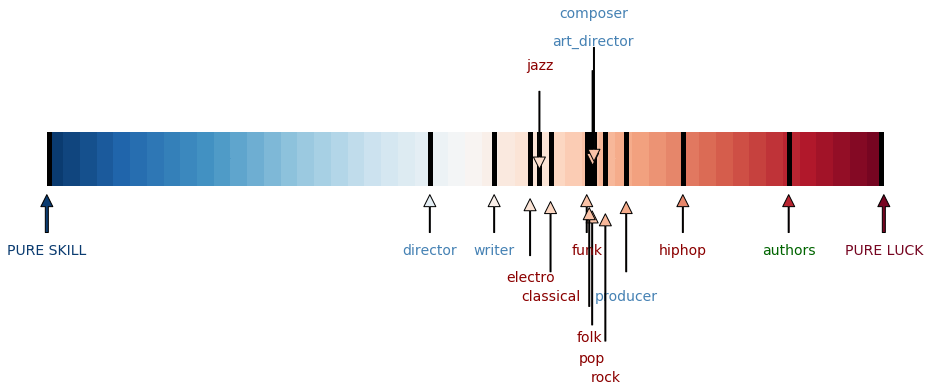

In [40]:
NNN    = 50.0
values = np.arange(0.0,1.0,1.0/NNN)
f, ax  = plt.subplots(1,1, figsize = (15,1))
colors = sns.color_palette("RdBu_r", int(NNN))
values = np.asarray([np.asarray(values), np.asarray(values)])

sns.heatmap(values, cmap=colors,  ax = ax, vmin=0, vmax = 1,linewidths = 0, cbar= False)
ax.axis('off')



actual_data = luck_skill_data
ypositions  = {k : 0.0001 for k, v in actual_data.items()}

ypositions['classical']      = 1.7
ypositions['electro']        = 1
ypositions['jazz']           = -6.8
ypositions['producer']       = 1.7
ypositions['art_director']   = -7.7
ypositions['composer']       = -8.7
ypositions['rock']           = 4.7
ypositions['pop']            = 4.0
ypositions['folk']           = 3.2


for ind, (title, val) in enumerate(actual_data.items()):

    xcoord = val * NNN
    
    ax.axvline(x=xcoord, ymin=-0.5, ymax=5.5, color = 'k', linewidth = 5)
  
    ax.annotate(title, xy=(xcoord,  2), xytext=(xcoord, 4.5 + ypositions[title]), 
                horizontalalignment = 'center', 
                fontsize = 14,
                color    = colors_field[title],
                arrowprops=dict(facecolor=colors[int(xcoord)], shrink=0.15,width = 1),)
    
 
ax.axvline(x=0, ymin=-0.5, ymax=5.5, color = 'k', linewidth = 10)
ax.annotate('PURE SKILL', xy=(0, 2), xytext=(0, 4.5), horizontalalignment = 'center', 
                fontsize = 14, color =colors[0],
                arrowprops=dict(facecolor=colors[0], shrink=0.15,width = 3), )

ax.axvline(x=NNN, ymin=-0.5, ymax=5.5, color = 'k', linewidth = 10)
ax.annotate('PURE LUCK', xy=(NNN, 2), xytext=(NNN, 4.5), horizontalalignment = 'center', 
                fontsize = 14, color =colors[-1],
                arrowprops=dict(facecolor=colors[-1], shrink=0.15,width = 3), )

plt.savefig('../../../../Dropbox/Artisic_careers_paper/text/Figures/F6.png', bbox_inches="tight")